# Monte Carlo, optimisation and search algorithms

## Introduction
In the lecture we introduced some key ideas related to optimisaton problems and searching of high dimensional space. In this session we will explore some of these ideas practically.

## The Travelling Salesman Problem: a model problem
To explore the behaviour of some possible approaches to optimisation and search we will consider a model problem. I have chosen a classic problem called the [Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem). The problem is this: we have $n$ points distributed in $N$-dimensional space (we'll stick to two-dimensions, so imagine a set of houses distributed around in an open landscape) and wish to find a route that visits every point (house) once, and once only, and returns to the starting point. The problem is to find the shortest such route. 

We will start by representing this problem in some Python code so that we can explore ways of optimising the route.

We begin by importing the usual modules:

In [1]:
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

We will store details of the salesman's "round" in an array called `roundmap`. This is essentially a list of coordinates of the locations of the "houses" that the salesman's route must visit. We will define a function that creates such an array and fills it with houses in random positions with coordinates between -0.5 and 0.5 in each direction.

In [2]:
def createmap(n):
    # Create a set of n points randomly distributes between -0.5 and 0.5 in 2d-space
    roundmap = np.random.rand(n,2)-0.5
    return roundmap

Throughout the notebook, we will use the term *map* to refer to the set of points that our salesman must visit. It is now easy to create a two-dimensional map with 10 points, as follows:

In [3]:
mymap = createmap(10)
print(mymap)

[[-0.0725776  -0.07133657]
 [ 0.32432518  0.2208482 ]
 [ 0.29403218 -0.45000466]
 [-0.49255452  0.12955253]
 [-0.13419724 -0.26383724]
 [ 0.45310523 -0.46881494]
 [ 0.48687328 -0.11914496]
 [-0.42602254 -0.20764391]
 [ 0.21145296 -0.10864098]
 [-0.1507842  -0.367578  ]]


Next we will write a function to set up an initial route between the points completely at random (Try to work out what it is doing):

In [4]:
def generateroute(roundmap):
    n = np.size(roundmap,0) # Find out how many points are in the roundmap
    route = np.zeros(n,dtype = int) # Set up an array to hold the order of the points in the route
    # We will now build a list of the points in the map in random order. This is our route.
    for i in range(n): # We need to generate a route which contains all n points in the map
        # For each iteration of the loop we need to add a new point to the route. We do this by choosing a new
        # point at random. There is a possibility that we will select a point that is already in the route.
        # We need to test for this and if we pick a point that is already used we try again by selecting a new random point.
        pointisnew = False # Set a flag to record whether our randomly chosen point is already in the route
        while not pointisnew: # Loop through the following code until we have picked a point that is not previously used
            # in the route. This will be flagged by setting pointnotused to True
            trialpoint = np.random.randint(low=0, high=n) # Choose a point at random
            pointisnew = True # Assume chosen point is not used, but check this in loop below
            for j in range(i): # Loop through all points previously added to route
                if trialpoint == route[j]: # Check if this point matches the one in the list of previously used points
                    pointisnew = False # If so flag that the point is not new, so that the while loop executes again
        # If the point is new, the while loop will exit and the following code will execute
        route[i] = trialpoint # add the new point to the route
        # Now go back to the start of the for loop unless all n points have been added to loop
    return route

When we pass our newly created map to the `generateroute` function it returns another array called `route` which contains details of the route. Have a think about how the `generateroute` function works: it picks points to visit using a random variable, but since we are only allowed to visit each point once it also keeps track of points already visited. We will now use this function to generate a random route:

In [5]:
myroute = generateroute(mymap)
print(myroute)

[3 9 0 5 2 6 7 8 1 4]


`myroute` simply contains a random sequence of integers from 0 to 9 denoting the order in which the points of `mymap` are to be visited. We have printed out the contents of our map and our route, but it would be nice to visualise them. Of course, we can use matplotlib for this. Since we are likely to want to visualise quite a lot of this sort of data, let's write a small function to produce a suitable plot:

In [6]:
def plotroute(roundmap,route):
    # Our route array contains the points in the order visited, but for our plot we also need to join the route
    # back to the starting point. So we create a new array, routep, with one more point in it which has the same number 
    # as the starting point.
    routep = np.zeros(np.size(route,0)+1,dtype=int)
    routep[:np.size(route,0)] = route[:]
    routep[-1] = route[0]
    plt.axes().set_aspect('equal')
    axes = plt.gca()
    axes.set_xlim([-0.5,0.5])
    axes.set_ylim([-0.5,0.5])
    plt.plot(roundmap[routep[:],0], roundmap[routep[:],1], 'bo-')

Now we can easily take a look at what we have so far:

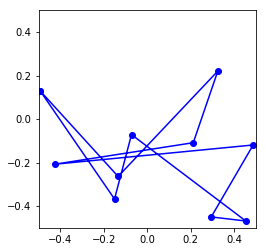

In [7]:
plotroute(mymap,myroute)

## The objective function
Recall that in an optimisation problem the *objective function* describes the quantity that we are trying to optimise. In this case we are looking for the shortest route, so the property of our system we want to optimise (to minimise in this case) is the length of the route. It would be useful to have a function that returns the length of the route for a given map:

In [8]:
def routelength(roundmap, route):
    n = np.size(roundmap,0)
    norm = n*np.sin(np.pi/n)
    distance = 0
    for i in range(n-1):
        distance = distance + (np.linalg.norm(roundmap[route[i+1]] - roundmap[route[i]]))
    distance = distance + np.linalg.norm(roundmap[route[0]] - roundmap[route[n-1]])
    return distance/norm

I have chosen to normalise the total length of the route by dividing by a factor of $n\sin(\pi/n)$ where $n$ is the number of points in the map. We will see why in a little while, but for now we can access the length of our route as follows:

In [9]:
print(routelength(mymap,myroute))

1.68980118927


We now have all the basic functionality that we need to explore the Travelling Salesman problem, so we can begin experimenting with some optimisation strategies.

## Global search by random sampling
Just about the simplest strategy is to repeatedly generate random routes between our set of points and choose the best of them as our optimised route. The code below does this for a map with 10 points in two dimensions. It tries a large number (`nattempts`) of random routes and records the current best length and best route as a function of the number of attempts.

In [10]:
# random search algorithm
n = 10
mymap = createmap(n)
nattempts = 10000
minlengths = []  # retain a list of the minimum route length found so far during the nattempts
minlength = 999999  # Initialise the minimum length so far to a very high number (the initial route will beat this)
for i in range(nattempts): # Randomly generate nattempts routes and keep a record
    myroute = generateroute(mymap) # Generate a random route
    thislength = routelength(mymap,myroute) # Get its length
    if(thislength < minlength): # Is this the shortest route so far?
        minlength = thislength # If so set the minlength to the new minimum length
        bestroute = myroute.copy() # and record a copy of the route with this new minimum length
    minlengths.append(minlength) # Add the current minimum length so far to the list

We can plot the evolution of the length of the route as a function of the number of random guesses attempted:

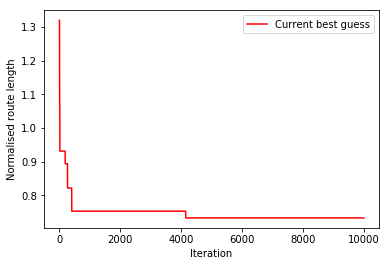

In [11]:
plt.plot(minlengths, 'r-', label='Current best guess')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()

And we can also take a look at the best walk that we have found so far:

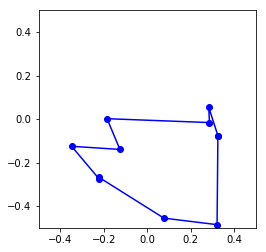

In [12]:
plotroute(mymap,bestroute)

### How do we know when we have found the *best* solution?
This looks like a good solution, but can we be sure it is the best? This is a general issue with optimisation problems: we can't be sure we have found the best answer unless we already know what that best answer is, in which case, there is not much point us putting in all this effort! However, this does suggest a strategy for testing out different algorithms: we ask them to solve a problem to which we know the answer. In this case we could, for example, use an arrangement of points for which the optimal route is obvious, perhaps by arranging the points so they are equally spaced around the circumference of a circle. We can write a simple function to produce a map of this type:

In [13]:
def circularmap(n):
    roundmap = np.zeros((n,2))
    for i in range(n):
        roundmap[i,:] = np.array([0.5*np.sin(2.0*np.pi*i/n),0.5*np.cos(2.0*np.pi*i/n)])
    return roundmap

Now we can try out our random search strategy on this carefully chosen map:

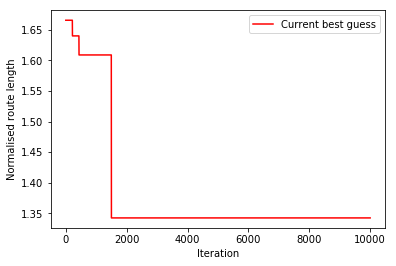

In [14]:
# random search algorithm
n = 10
mymap = circularmap(n)
myroute = generateroute(mymap)
nattempts = 10000
minlengths = []
minlength = 999999
for i in range(nattempts):
    myroute = generateroute(mymap)
    thislength = routelength(mymap,myroute)
    if(thislength < minlength):
        minlength = thislength
        bestroute = myroute.copy()
    minlengths.append(minlength)

plt.plot(minlengths, 'r-', label='Current best guess')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()


Now we can appreciate the reason for normalising the total route length by a factor of $n\sin(\pi/n)$: under this normalisation, the optimal route length will be 1.0 and we can judge the success of our chosen optimisation strategy. How well did it do in the above example?

It is probable, though not certain, that the above example failed to find the optimum route. We can see how it did by visualising the best guess:

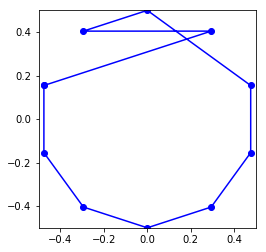

In [15]:
plotroute(mymap,bestroute)

## Local search by random mutation
In the above example we were sampling completely randomly from the full range of possible routes. Each sample was completely independent of those that came before and after and so we were exploring the full search space in a completely unbiased way. An alternative strategy is to start from a random choice of route and then make random changes to it, one at a time, to explore the range of possible routes. In this case each new route is closely related to the one before and we are always searching for new routes that are local to the choices in the recent past. To try out this search strategy we will define a function `swappoints`, which simply takes two specified points in the given route and swaps their order:

In [16]:
def swappoints(route,swap):
    savepoint = route[swap[0]]
    route[swap[0]] = route[swap[1]]
    route[swap[1]] = savepoint

Take a look at the code below and try to understand what it is doing. It implements a local approach to search using the `swappoints()` function defined above. Run the code and examine the result.

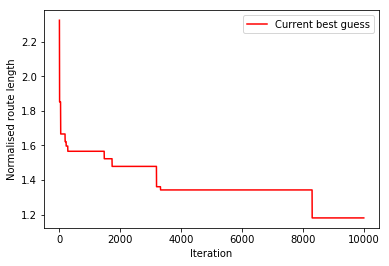

In [17]:
# local search
n = 10
mymap = circularmap(n)
myroute = generateroute(mymap)
nattempts = 10000
minlengths = [] # List of best guess so far at each iteration
minlength = 999999
n = np.size(mymap,0)
for i in range(nattempts):
    swap = np.random.randint(low=0, high=n, size=2) # Generate a random pair of integers - the points to swap
    swappoints(myroute,swap)
    # Check if new route is shorter than current best guess. If it is, save a copy of the walk and record its length
    thislength = routelength(mymap,myroute)
    if(thislength < minlength):
        minlength = thislength
        bestroute = myroute.copy()
    minlengths.append(minlength)
    
plt.plot(minlengths, 'r-', label='Current best guess')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()


How does this approach perform? We can take a look at the resulting best guess for the optimised walk:

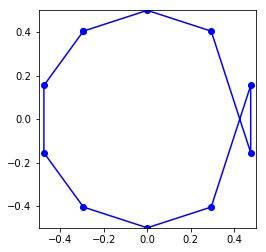

In [18]:
plotroute(mymap,bestroute)

## Downhill search
Both of the algorithms above have one thing in common: they navigate around the space of possible routes without taking any account of whether the series of guesses is getting better or worse. This can often make such random approaches to searching very inefficient. We can see this if we try out the above example again, but this time record not just the length of the best route so far, but also the length of each route that we try: 

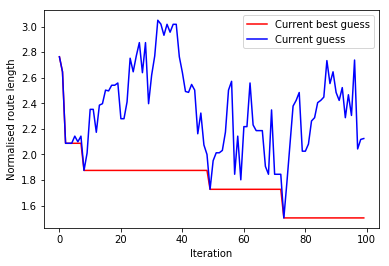

In [21]:
# local search
mymap = circularmap(n)
myroute = generateroute(mymap)
nattempts = 100
minlengths = [] # List of best guess so far at each iteration
lengths = [] # List of current guess at each iteration
minlength = 999999
n = np.size(mymap,0)
for i in range(nattempts):
    swap = np.random.randint(low=0, high=n, size=2)
    swappoints(myroute,swap)
    thislength = routelength(mymap,myroute)
    if(thislength < minlength):
        minlength = thislength
        bestroute = myroute.copy()
    minlengths.append(minlength)
    lengths.append(thislength)

plt.plot(minlengths, 'r-', label='Current best guess')
plt.plot(lengths, 'b-', label='Current guess')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()

In the above plot, the red line shows the best guess so far and the blue line shows the length of the current guess. We can see that we spend a lot of time moving away from the current best guess and exploring much longer routes. This suggests an alternative strategy: what if we explore new routes in such a way that we only make changes to our route that result in a shorter route?

We can implement this strategy pretty simply using our existing functions as follows:

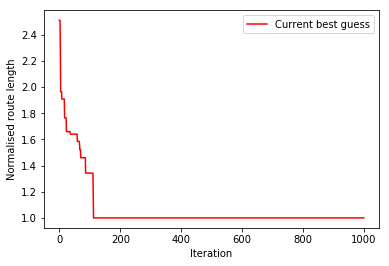

In [22]:
# downhill search
mymap = circularmap(n)
myroute = generateroute(mymap)
nattempts = 1000
minlengths = []  # Empty list to record history of best guess so far at each attempts
minlength = 999999
n = np.size(mymap,0)
for i in range(nattempts):
    pointstoswap = np.random.randint(low=0, high=n, size=2) # Choose two random points in the list to swap
    swappoints(myroute,pointstoswap) # Swap these points
    thislength = routelength(mymap,myroute)
    if(thislength < minlength): # Check if new route is shorter than current best guess. If it is, continue to make changes from here. 
        minlength = thislength
    else: # If it isn't reverse this swap and try again.
        swappoints(myroute,pointstoswap)  # Swap points back if new guess did not improve on last one.
    minlengths.append(minlength)
    
plt.plot(minlengths, 'r-', label='Current best guess')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()

When the above code attempts a random swapping of two points, it checks whether the length of the route has increased or decreased. If it has increased, it *rejects* the change and undoes the swap. If the length of the route has decreased then it *accepts* the swap and proceeds from the new, shorter route.

You should find that even in relatively few tries, this approach finds the known optimal route.

## Comparing algorithm performance 
We can compare the performance of the random and downhill approaches to search directly for our circular map. To do this, we will define a couple of new functions which implement a search involving a given number of swaps for each search algorithm. These functions are very similar to the bits of code that we ran above for each search method, but by wrapping up the code in functions we can make it reusable, without the need to keep copying and pasting. Try to understand how the below functions work:

In [23]:
def randomsearch(roundmap, route, nswaps):
    n = np.size(roundmap,0)
    minlengths = []
    thislength = routelength(roundmap,route)
    minlength = thislength
    minlengths.append(minlength)
    for i in range(nswaps):
        swap = np.random.randint(low=0, high=n, size=2)
        swappoints(route,swap)
        thislength = routelength(roundmap,route)
        if(thislength < minlength):
            minlength = thislength
        minlengths.append(minlength)
    return minlengths

def downhillsearch(roundmap, route, nswaps):
    n = np.size(roundmap,0)
    minlengths = []
    thislength = routelength(roundmap,route)
    minlength = thislength
    minlengths.append(minlength)
    for i in range(nswaps):
        pointstoswap = np.random.randint(low=0, high=n, size=2)
        swappoints(route,pointstoswap)
        thislength = routelength(roundmap,route)
        if(thislength < minlength):
            minlength = thislength
        else:
            swappoints(route,pointstoswap)
        minlengths.append(minlength)
    return minlengths

#### <span style="color: red"> Task 1:</span> Compare the two methods using the code below
Try running the code below several times. You should find that most of the time (though not always) the downhill search method finds a shorter path and also apporaches it more quickly.

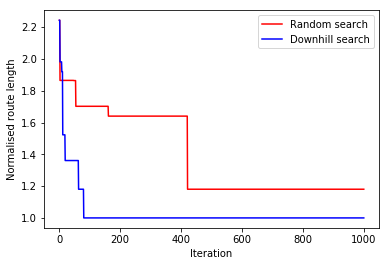

In [48]:
n = 10
mymap = circularmap(n)
myroute = generateroute(mymap)
myrouterandom = myroute.copy() # Create two copies of the route so that both algorithms are working on the same problem
myroutedownhill = myroute.copy()

nswaps = 1000

minsrandom = randomsearch(mymap, myrouterandom, nswaps)
minsdownhill = downhillsearch(mymap, myroutedownhill, nswaps)

plt.plot(minsrandom, 'r-', label='Random search')
plt.plot(minsdownhill, 'b-', label='Downhill search')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()

#### <span style="color: red"> Task 2:</span> Try out the two search methods on a more general map
Copy the code above into a new cell and try out a more general map (a random map rather than a circular one).

You should find that, on average, the downhill search continues to outperform the random search.

## The curse of dimensionality
So far we have been exploring quite small maps with only 10 points. What happens if we consider much larger maps?

#### <span style="color: red"> Task 3:</span> Try out the two search methods on a larger, general map
Use the same code as before, but try a random map with 50 points. Try also running the test for more iterations: try `nswaps=10000`. Plot out the final routes from the two algorithms and compare. What do you observe?

You should find that now we have a larger map, the random search algorithm is significantly worse than the downhill search. You should also see that the resulting route from the random algorithm looks extremely sub-optimal, whereas the route from the downhill search is at least somewhat sensible, with some sections of the route quite well optimised. Why is this? As we increase the number of points in our map, the number of possible routes increases dramatically. We can be more precise about this....

Consider first the case of two points $\left\{A,B\right\}$. How many different ways of visiting these points are there. We have two choices for the first point to visit, either $A$ or $B$, then there is no choice over the second point. So overall there are $2\times 1 = 2$ possible walks. If we had three points $\left\{A,B,C\right\}$ we have 3 possible choices for the first point, then two remaining choices for the second point and then no choice over the third point. This gives us $3\times 2\times 1 = 6$ possible routes. For $N$ points there are $N\times (N-1)\times (N-2)\times \dots \times 2 \times 1$ routes. We denote this quantity $N!$, pronounced "N-factorial".

So for 50 points, the number of possible routes is:

$$
(50)! = 50\times 49\times 48\times\dots \times 3\times 2\times 1 \approx 3\times 10^{64},
$$

A collosal number. In the above task we only tried 10000 swaps in our optimisation so it is remarkable that the downhill search managed to find even a remotely sensible route!

(To be strictly correct we should note that since our routes are circular, it doesn't matter where in a given route we begin so in a map of $N$ points there are $N$ equivalent routes for every choice of order. In addition to this, it doesn't matter which way round we make our route and so the total number of truly distinct routes is actually given by $(N-1)!/2$, rather than $N!$.) 

## The problem of trapping in local minima
Let's try a really long run (100,000 swaps) of the downhill search algorithm for the larger map and examine the result. (This may take a minute or so to run!:

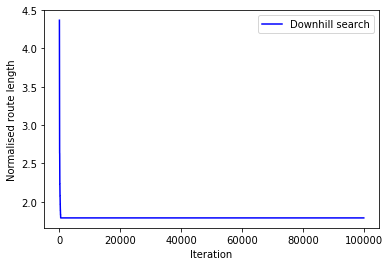

In [53]:
# downhill search
n = 20
mymap = createmap(n)
myroute = generateroute(mymap)
myroutedownhill = myroute.copy()

nswaps = 100000
minsdownhill = downhillsearch(mymap, myroutedownhill, nswaps)

plt.plot(minsdownhill, 'b-', label='Downhill search')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()

You will probably see that the algorithm rapidly works its way to a fairly short route, but that further searching does not provide any further improvement. We can also examine the final route:

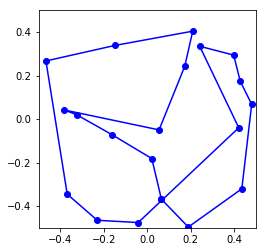

In [54]:
plotroute(mymap,myroutedownhill)

Your exact result will depend on the random number generator, but you will probably find that the final route is such that you could easily propose a better solution simply by inspection. However, you will also probably find that no swapping of a pair of points in the route will give an improvement. Since our downhill algorithm involves such swaps of points, this means that it is impossible for the algorithm to do any better - all possible changes from here will result in a *longer* route and so will not be permitted. We are trapped in a *local minimum* of the system: all the nearby routes accessible to the algorithm are worse than this. We haven't found the *global minimum*, since a better solution for the route *does* exist; there is just no way for our algorithm to find it. This is a shortcoming of local downhill search as we have implemented it here. A random search does not have this shortcoming, but unfortunately, with 20 points in the map, the number of possible routes ($19!/2 \approx 6\times 10^{16}$) is far too large to search randomly.

## Escaping local mimima - simulated annealing
The problem that we encountered above, of becoming trapped in a local minimum, can be solved by allowing some swaps of points that actually *increase* the route length, provided they do not increase it by too much. If done carefully, this should allow us to escape local minima and give us more chance of finding the global minimum. A search strategy that adopts this approach is known as *simulated annealing*. The reason for this name is that the method involves a temperature-like parameter which is gradually reduced during the course of the search. Now, instead of accepting only changes to the route that reduce the length, we also accept changes that increase the length with a certain probability. For a swap of points resulting in a change in length $\Delta L$ our rule is:

$$ 
\Delta L \leq 0  :  \textrm{accept}, \qquad \Delta L \gt 0  :  \textrm{accept with probability } \exp(-\Delta L / k_{\textrm{B}}T).
$$

The probability has the same form as a *Boltzmann factor* in statistical mechanics. Clearly we will have to choose our range of temperatures carefully so that the scale of $k_{\textrm{B}}T$ matches the scale of $\Delta L$ in any given problem. Note also that this is only an analogy with real annealing. In a physical process, the factor $k_{\textrm{B}}T$ would have the dimensions of energy. In any given optimisation problem we just treat $k_{\textrm{B}}T$ as a compound factor with the same dimensions as the property that we are trying to optimise. In our case, $k_{\textrm{B}}T$ implicitly has the dimensions of length.

The below code implements simulated annealing for our Travelling Salesman problem:

In [55]:
def annealingsearch(roundmap, route, nswaps, kT):
    n = np.size(roundmap,0)
    ntsteps = 10 # Change the temperature in this many steps during the optimisation
    dkT = kT/(ntsteps-1)  # Vary the temperature in amounts of this size each step
    tstepinc = int(nswaps/ntsteps) # number of swaps between temperature variations
    lengths = [] # Keep a record of the lengths during the search
    prevlength = routelength(roundmap,route)
    lengths.append(prevlength)
    for i in range(nswaps):
        pointstoswap = np.random.randint(low=0, high=n, size=2)
        swappoints(route,pointstoswap)
        currentlength = routelength(roundmap,route)
        # Test change in length due to swap and choose whether to accept
        if(currentlength <= prevlength or (kT > 0.0 and np.random.rand() < np.exp(-1.0*(currentlength-prevlength)/kT))):
            # Note that in the above test the temperature-based condition is only applied if the temperature is non-zero
            # This allows a period of downhill search (equivalent to T=0) at the end of the run, without causing 
            # "division by zero" errors
            prevlength = currentlength
        else:
            swappoints(route,pointstoswap)
        lengths.append(prevlength)
        
        if i%tstepinc == 0 and i>0: # Reduce the temperature by dkT every tstepinc attempts
            kT = kT - dkT  
            if kT < 1e-5: # If the temperature gets very small, set to exactly zero to stop the algorithm becoming unstable
                kT = 0.0
    return lengths

We will now compare the performance of this algorithm to the downhill search for a map of 20 points. Run the code below and examine the results:

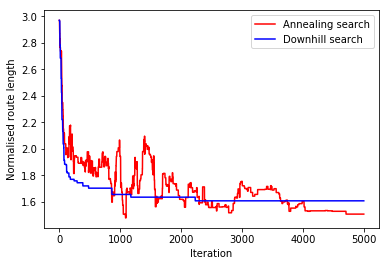

In [64]:
n = 20
T = 0.05
mymap = createmap(n)
myroute = generateroute(mymap)
myroutedownhill = myroute.copy()
myrouteanneal = myroute.copy()

nswaps = 5000

minsanneal = annealingsearch(mymap, myrouteanneal, nswaps, T)
minsdownhill = downhillsearch(mymap, myroutedownhill, nswaps)

plt.plot(minsanneal, 'r-', label='Annealing search')
plt.plot(minsdownhill, 'b-', label='Downhill search')
plt.xlabel('Iteration')
plt.ylabel('Normalised route length')
plt.legend()

You may have to run the code a few times to get a good impression of the performance, but in general you should find that the simulated annealing approach ultimately arrives at a shorter route than the simple downhill search. The downhill search will tend to arrive at a fairly well optimised route very quickly, but then get stuck in a local minimum, whereas the simulated annealing algorithm permits some swaps that increase the route length, which will be visible as fluctuations in the plot. You will see that over the course of the simulation, because we gradually reduce the fictitious temperature, the allowed size of these fluctuations decreases. Towards the end, when $T=0$, we effectively have the equivalent of a downhill search because the probability of accepting any increase in route length goes to zero.

#### <span style="color: red"> Task 4:</span> Examine the final paths from the two approaches to search tried above

## Performance of algorithms
To get a better idea of the performance of the downhill search and simulated annealing algorithms we will run each search method on a series of randomly generated maps and build a histogram of the lengths of the final routes. The code below tries each algorithm out on 20 randomly generated maps. This is an advantage of wrapping the code used to run the searches within functions: we can now reusue it multiple times within a loop in order to get some statistics on the performance of the different methods. This may take a liitle while to run, but I have included a counter to show the progress through the loop.

Currently calculating map: 0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.

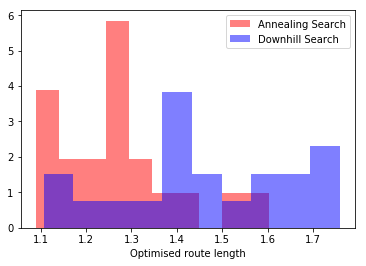

In [67]:
n = 20
T = 0.05
nattempts = 20
nswaps = 5000
minlistdownhill = []
minlistanneal = []
print('Currently calculating map: ', end='')
for i in range(nattempts):
    print(str(i)+'.', end='')
    mymap = createmap(n)
    myroute = generateroute(mymap)
    myroutedownhill = myroute.copy()
    myrouteanneal = myroute.copy()
    minsanneal = annealingsearch(mymap, myrouteanneal, nswaps, T)
    minsdownhill = downhillsearch(mymap, myroutedownhill, nswaps)
    minlistdownhill.append(minsdownhill[-1])
    minlistanneal.append(minsanneal[-1])
    
n, bins, patches = plt.hist(minlistanneal, 10, normed=1, facecolor='red', alpha=0.5, label='Annealing Search')
n, bins, patches = plt.hist(minlistdownhill, 10, normed=1, facecolor='blue', alpha=0.5, label='Downhill Search')
plt.xlabel('Optimised route length')
plt.legend()

This should make the point quite clearly that the simulated annealing approach is performing better in this case. However, this is only part of the story. If you examine some of the plots of the route length as a function of the number of swaps earlier in the notebook, you will see that one strength of the downhill algorithm is that it converges very quickly to its best guess answer. So if we are less interested in finding a perfect solution and more interested in getting a reasonable answer quickly, then perhaps the downhill search approach is better. The code below defines two functions which implement our two search methods and return the time taken to get to a particular target value for the route length. Don't worry too much about the contents of these functions as we will not make much use of them, but do take a look if you have time and try to understand how they work.

In [68]:
def downhilltime(roundmap, route, maxswaps, target):
    n = np.size(roundmap,0)
    thislength = routelength(roundmap,route)
    minlength = thislength
    found = False
    time = 0
    while not found:
        swap = np.random.randint(low=0, high=n, size=2)
        swappoints(route,swap)
        thislength = routelength(roundmap,route)
        if(thislength < minlength):
            minlength = thislength
        else:
            swappoints(route,swap)
            thislength = routelength(roundmap,route)
        if minlength - target < 1e-3:
            found = True
        elif time >= maxswaps-1:
            found = True
        time = time + 1
    return time

def annealtime(roundmap, route, nswapanneal, kT, maxswaps, target):
    n = np.size(roundmap,0)
    ntsteps = 10
    dkT = kT/(ntsteps-1)
    tstepinc = int(nswapanneal/ntsteps)
    prevlength = routelength(roundmap,route)
    found = False
    time = 0
    while not found:
        swap = np.random.randint(low=0, high=n, size=2)
        swappoints(route,swap)
        currentlength = routelength(roundmap,route)
        if(currentlength <= prevlength or (kT > 0.0 and np.random.rand() < np.exp(-1.0*(currentlength-prevlength)/kT))):
            prevlength = currentlength
        else:
            swappoints(route,swap)
        if time%tstepinc == 0 and i>0:
            kT = kT - dkT  
            if kT < 1e-5:
                kT = 0.0
        if prevlength - target < 1e-3:
            found = True
        elif time >= maxswaps-1:
            found = True
        time = time + 1
    return time

To make our analysis simpler we will choose to use a circular map of points, so that the optimum solution is known. We can then use the above functions to find out how long it takes to reach this optimal solution. The code below does this and plots a histogram of the search times, along with the success rate for each algorithm in finding the optimal solution:

Currently calculating map: 0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.

Annealing search finds optimum 95.0% of the time
Downhill search finds optimum 35.0% of the time


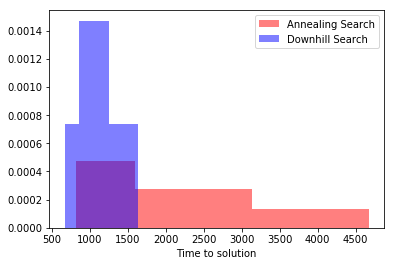

In [69]:
n = 20
T = 0.05
nattempts = 20
maxswaps = 20000
nswapanneal = 5000
timelistdownhill = []
timelistanneal = []
targetlength = 1.0
print('Currently calculating map: ', end='')
for i in range(nattempts):
    print(str(i)+'.', end='')
    mymap = circularmap(n)
    myroute = generateroute(mymap)
    myroutedownhill = myroute.copy()
    myrouteanneal = myroute.copy()
    timeanneal = annealtime(mymap, myrouteanneal, nswapanneal, T, maxswaps, targetlength)
    timedownhill = downhilltime(mymap, myroutedownhill, maxswaps, targetlength)
    timelistdownhill.append(timedownhill)
    timelistanneal.append(timeanneal)
print()
print()
n, bins, patches = plt.hist([t for t in timelistanneal if t<maxswaps], 5, normed=1, facecolor='red', alpha=0.5, label='Annealing Search')
n, bins, patches = plt.hist([t for t in timelistdownhill if t<maxswaps], 5, normed=1, facecolor='blue', alpha=0.5, label='Downhill Search')
plt.xlabel('Time to solution')
plt.legend()
print('Annealing search finds optimum ' + str(100*(1-sum([1 for t in timelistanneal if t==maxswaps])/nattempts)) + '% of the time')
print('Downhill search finds optimum ' + str(100*(1-sum([1 for t in timelistdownhill if t==maxswaps])/nattempts)) +'% of the time')

The annealing search is more reliable for finding the optimal solution, but the downhill search reaches its conclusion more quickly.

#### <span style="color: red"> Task 5:</span> Examine the performance of the algorithms when we do not need the exact solution
Copy the above code and run it to examine the performance of the algorithms assuming we are happy with a `targetlength` for the path that is 10% longer than the shortest possible.

## Genetic algorithm
The first approach to optimisation that we tried today was random sampling, in which we repeatedly generated a completely random route and kept a record of the best guess so far. This worked fairly well for a map with only a small number of points, but rapidly became far too inefficient when we increased the number of points. To improve our approach to search we then introduced the idea of local search. Unlike in a random search each subsequent guess is a small change from the last. In this way, once we have found a good solution, we can preserve a memory of it. In the case of downhill search this allows us to progressively improve upon a good guess. One problem with the straight downhill search method, though, is that it is easy to get trapped in a local minimum. The last approach to search that we will try is one that combines elements of local downhill search and elements of global search: a genetic algorithm.

The basic idea here is to take a cue from nature: natural selection acts to optimise the fitness of organisms for their environment, but an important feature of the process is mating, whereby features of two parent organisms are combined to create offspring. This combination of features from different parents allows the offpring to avoid becoming trapped in local minima, which we can see as a situation in which sub-optimal features are endlessly propagated through subsequent generations.

The idea behind our genetic algorithm will be to generate an initial population of routes at random. We will then take the best (shortest) two routes and use these as our parents. One could come up with multiple ways to breed offpring from these parents, but our approach is to randomly select half of the route from each parent and combine them to create a new route. We do this multiple times to create a population of offspring and select the best of these to be our new parents. Then we breed new offspring from the best parents and so on, repeating for a chosen number of iterations.

First we define a function to implement the breeding of a new offspring route from a pair of parent routes:

In [71]:
def breedpair(parentroute1,parentroute2):
    n = np.size(parentroute1) # Get the size of the routes
    childroute = np.zeros(n, dtype=int)
    cutpoint = np.random.randint(low=0, high=n)
    for s in range(int(n/2)):
        childroute[s] = parentroute1[(cutpoint+s)%n]
    for s in range(int(n/2)):
        childroute[(s+int(n/2))%n] = parentroute2[(cutpoint+int(n/2)+s)%n]
    return childroute

Let's try out this function with a pair of randomly generated routes on a circular map:

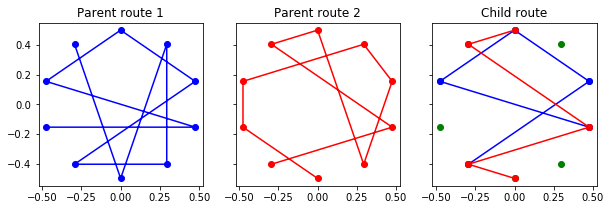

In [74]:
n = 10
mymap = circularmap(n)
parentroute1 = generateroute(mymap)
parentroute2 = generateroute(mymap)

childroute = breedpair(parentroute1,parentroute2)

f, ((ax1, ax2, ax3)) = plt.subplots(1,3, sharex='col', sharey='row',figsize=(10,3))
ax1.plot(mymap[parentroute1[:],0], mymap[parentroute1[:],1], 'bo-')
ax1.set_title("Parent route 1")
ax2.plot(mymap[parentroute2[:],0], mymap[parentroute2[:],1], 'ro-')
ax2.set_title("Parent route 2")
ax3.plot(mymap[:,0], mymap[:,1], 'go')
ax3.plot(mymap[childroute[0:int(n/2)],0], mymap[childroute[0:int(n/2)],1], 'bo-')
ax3.plot(mymap[childroute[int(n/2):n],0], mymap[childroute[int(n/2):n],1], 'ro-')
ax3.set_title("Child route")



We have highlighted the parts of the offspring route to show which parent they are derived from. You will probably find that there are some problems with the offspring route: it is likely that some of the points will appear twice in the offspring and some will not appear at all. We need to fix this. We need a bit of logic to make sure that each point in the map appears once and once only in the offspring route. This process can be seen as akin to the introduction of random mutations in the offspring in a breeding population in nature, which is an important feature of the process of evolution. We now define a function to fix any problems in the offspring route:

In [75]:
# Don't worry if you don't understand how this function works, 
# but do spend some time trying to work it out if you want a challenge
def fixroute(inputroute):
    n = np.size(inputroute,0)
    missing = [x for x in list(range(n)) if x not in inputroute[:]] # List of points not included in route
    present = [] # List of points included in route
    dupes = []   # List of points included twice in route
    for s in range(n):
        if inputroute[s] in present:
            dupes.append(s)
        present.append(inputroute[s])
    for s in range(len(dupes)):
        inputroute[dupes[s]] = missing[s]
    return

Now let's try this out on our problematic offspring from above:

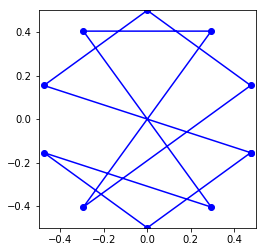

In [76]:
fixroute(childroute)
plotroute(mymap,childroute[:])

That seems to have fixed the problem!

We now have nearly all the machinery that we need to try out this approach to optimisation. When we do so we will begin with a population containing a number of routes that we can use for breeding offspring. To help us out we need one more function, defined below. It takes the population and implements the breeding process. This involves finding the best two routes in the population to use as parents. It then produces a chosen number of offspring and fixes any problems using the functions that we defined previously. Finally it selects the best of these to use as the new population of routes for further evolution:

In [77]:
def breedpopulation(roundmap, routes, nbreed):
    # Function takes a map of points and a population of routes, plus a number of offspring to breed from the parents.
    npopulation = np.size(routes,0) # Get the size of the routes and the number of routes in the population
    n = np.size(routes,1)
    #temproutes = np.zeros((nbreed,n), dtype=int)
    # First find two routes with shortest and second-shortest lengths
    bestlengths = [99,99]
    bestpair = [0,0]
    best = 0
    for i in range(npopulation):
        # This loop checks all the routes and finds the best two. The logic is a little complex, but see if you 
        # can work it out. Don't worry if you can't though.
        length = routelength(roundmap,routes[i,:])
        if length < bestlengths[(best+1)%2]:
            bestlengths[(best+1)%2] = length
            bestpair[(best+1)%2] = i
        if length < bestlengths[best]:
            best = (best+1)%2
    # bestpair now contains the index of the best (shortest) two routes which will now be used as parents
    newbestindices = []
    newbestlengths = []
    worstbestindex = 0
    worstbestlength = 99.0
    # Now breed new offspring routes
    offspringroutes = np.zeros((nbreed,n), dtype=int)
    for j in range(nbreed):
        childroute = breedpair(routes[bestpair[0]],routes[bestpair[1]]) # Breed a new route from parents
        fixroute(childroute) 
        offspringroutes[j,:] = childroute[:] # Add new child route to list to build a new list of routes
        length = routelength(roundmap,offspringroutes[j,:])
        if j == 0:
            # Add index of first of offspring to list of best offspring routes
            newbestindices.append(j)
            newbestlengths.append(length)
        elif len(newbestindices) < npopulation:
            # If list of best offspring is not yet full, add index of offspring to list
            newbestindices.append(j)
            newbestlengths.append(length)
        elif length < worstbestlength:
            # If list is full, only add index of offspring to list if it is shorter than current longest route in list 
            # of best offspring. Add it to the offspring list in place of the longest route in list
            newbestindices[worstbestindex] = j
            newbestlengths[worstbestindex] = length
        # Now hunt for the current longest route in the offspring list. This will be the next one to be replaced 
        # by a shorter offspring route
        worstbestlength = 0
        for s in range(len(newbestindices)):
            if newbestlengths[s] > worstbestlength:
                worstbestlength = newbestlengths[s]
                worstbestindex = s
    # Now copy the best of the offspring routes into the array of routes
    for s in range(npopulation):
        routes[s,:] = offspringroutes[newbestindices[s]]

The code below implements the genetic algorithm search method for a population of 20 routes on a circular map 20 points. We want to time how long the code takes so run the next cell first.

In [78]:
import timeit

Now run the code below and examine the results.

Code took 0.36s to execute
Best route length was 1.58


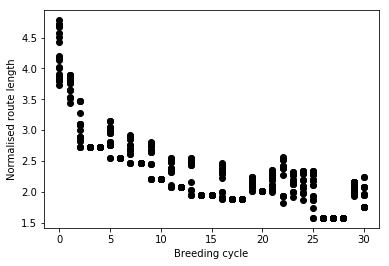

In [79]:
start_time = timeit.default_timer()
n = 20
ncopies = 20 # Number of routes in population
nbreed = 40  # Number of offpring to create in each breeding cycle
ncycles = 30 # Number of breeding cycles to use
# Arrays to hold routes and history of route lengths
myroutes = np.zeros((ncopies,n), dtype=int)
routelengths = np.zeros((ncycles+1,ncopies), dtype=float)
# Create a cricular map
mymap = circularmap(n)
# Generate population of initial routes at random
for i in range(ncopies):
    myroutes[i,:] = generateroute(mymap)  
# Caclulate and record initial route lengths
for i in range(ncopies):
    routelengths[0,i] = routelength(mymap,myroutes[i,:])
# Breed for requested number of cycles, recording routelengths each cycle
for s in range(ncycles):
    breedpopulation(mymap, myroutes, nbreed)
    for i in range(ncopies):
        routelengths[s+1,i] = routelength(mymap,myroutes[i,:])
elapsed = timeit.default_timer() - start_time
# Plot history of routelengths
for i in range(ncopies):
    plt.plot(routelengths[:ncycles+2,i],'ko')
plt.xlabel('Breeding cycle')
plt.ylabel('Normalised route length')
print('Code took ' + str(round(elapsed,2)) + 's to execute')
print('Best route length was ' + str(round(np.min(routelengths[:,:]),2)))

You may have noticed two things about the above. The first is that it settles to a solution that is far from perfect: you will probably find the final route lengths are around double the length of the optimum route. However, the second thing to observe is that the genetic algorithm reaches this solulution very fast. Perhaps this is the strength of this algorithm: it achieves a reasonable solution very quickly. We can test this possibility further:

#### <span style="color: red"> Task 6:</span> Test the genetic algorithm on a very large map
Copy the code from above and amend it so that the number of points in the map is 500. This is the largest map that we have yet considered and it would take a long time to find the optimum route using our other search methods. Run the code for 30 breeding cycles and see how long it takes and how good the final solutions are.

#### <span style="color: red"> Task 7:</span> Examine one of the final routes
You will probably find that the genetic algorithm rapidly settles to some solution, which is still some way off the optimum length of 1.0. However, this is a very large map and only a few flaws in the route would cause such a sub-optimal solution. Plot out some of the final routes to see how they look:

#### <span style="color: red"> Task 8:</span> Compare the performance of the genetic algorithm with that of the downhill search
Copy some suitable code from earlier in the notebook to implement a *downhill search* on a circular map with 500 points. Add the necessary code for timing the execution of the cell and compare the performance with that of the genetic algorithm. How good a solution does the downhill search algorithm produce in the same time it took to run the genetic algorithm above? How long would it take to reach a solution as good as the one the genetic algorithm found? (note that this might be longer than you are prepared to wait!).

Hint 1: The lines required to capture the time of execution can be found in the cell for the genetic algorithm above. They are as below, you just need to include them in the correct place:

`start_time = timeit.default_timer()`

`elapsed = timeit.default_timer() - start_time`

`print('Code took ' + str(round(elapsed,2)) + 's to execute')`

Hint 2: Start by asking for around 10000 swaps. That should give enough history to judge performance against the genetic algorithm above.


#### <span style="color: red"> Task 9:</span> Think about what you have done today
Think back over the different approaches to search that you have used today. Which of those approaches work best in which cases? Can you think how they might apply to other sorts of optimisation problems that you might want to solve?